In [1]:
import os
import pickle
import numpy as np
import pandas as pd

In [2]:
import torch
import torchvision

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Code type using for Pytorch: {device}")

Code type using for Pytorch: cuda


In [4]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Define Model

In [5]:
base_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
base_model

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
in_features_dim = base_model.roi_heads.box_predictor.cls_score.in_features
in_features_dim

1024

In [7]:
# load class2label dict for number of classes and dataset instance
with open("class2label_dict.pkl", "rb") as file:
    class2label = pickle.load(file)

class2label

{'Bus': 1, 'Truck': 2, 'background': 0}

In [8]:
classes_num = len(class2label)

re-define the ROI head

In [9]:
base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features_dim, classes_num)
base_model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [10]:
# load model to GPU RAM if using GPU
model = base_model.to(device)

# Prepare for model training

## define loss function

In [11]:
optimizer = torch.optim.SGD(base_model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

## define data loader

In [12]:
# reuse the Dataset for fetching image and labels
from preprocesses import ImageLabelDataset

load data

In [13]:
data_root = "data"
labels_df = pd.read_csv(os.path.join(data_root, "df.csv"))
labels_df.head(10)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
5,0002914fa805e227,xclick,Truck,1,0.061250,0.966875,0.125399,0.974495,1,0,...,1,0,0.756875,0.966875,0.501875,0.061250,0.974495,0.598300,0.125399,0.382572
6,00036603fa39fa85,xclick,Truck,1,0.058125,0.983125,0.053333,0.940000,0,0,...,0,0,0.058125,0.598750,0.983125,0.710000,0.550000,0.053333,0.337778,0.940000
7,0004d5a9dd44ab6a,xclick,Truck,1,0.035625,0.188125,0.189893,0.320827,0,0,...,0,0,0.115000,0.035625,0.139375,0.188125,0.189893,0.245023,0.320827,0.236600
8,0004d5a9dd44ab6a,xclick,Truck,1,0.094375,0.897500,0.147014,0.934150,0,0,...,0,0,0.365000,0.094375,0.333750,0.897500,0.147014,0.609495,0.934150,0.822358
9,0004d5a9dd44ab6a,xclick,Truck,1,0.860625,0.999375,0.249617,0.390505,1,0,...,0,0,0.992500,0.999375,0.860625,0.921250,0.249617,0.294028,0.325421,0.390505


split data into train-set and validate-set

In [14]:
train_ids, validate_ids = train_test_split(labels_df.ImageID.unique(), test_size=0.1, random_state=99)
train_df, validate_df = labels_df[labels_df['ImageID'].isin(train_ids)], labels_df[labels_df['ImageID'].isin(validate_ids)]
print(f"Number of training samples: {len(train_df)}, Number of validating samples: {len(validate_df)}")

Number of training samples: 21598, Number of validating samples: 2464


In [15]:
train_dataset = ImageLabelDataset(train_df, "data/images/images", class2label, device)
validate_dataset = ImageLabelDataset(validate_df, "data/images/images", class2label, device)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))
validate_loader = DataLoader(validate_dataset, batch_size=8, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))

### define function for training and validating the model for each batch

In [17]:
def train_by_batch(batch, model, optimizer):
    model.train()
    inputs, targets = batch
    inputs = list(img.to(device) for img in inputs)
    targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
    optimizer.zero_grad()
    # losses is dict of loss for classifier & box regression, object score, rpn box regression
    losses = model(inputs, targets)
    # total_loss is a 1D tensor
    total_loss = sum(v for v in losses.values())
    total_loss.backward()
    optimizer.step()
    return total_loss, losses

In [18]:
@torch.no_grad() # disable gradient computation 
def validate_by_batch(batch, model):
    model.train() # to obtain the losses, model needs to be in train mode
    inputs, targets = batch
    inputs = list(img.to(device) for img in inputs)
    targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(inputs, targets)
    total_loss = sum(v for v in losses.values())
    # no backward step and training step
    return total_loss, losses

# Training Loop

In [19]:
batch_num = len(train_loader)
model_path = os.path.join('models',)
epochs_num = 5
for epoch in range(epochs_num):
    for id_, batch in enumerate(train_loader):
        total_loss, losses_dict = train_by_batch(batch, model, optimizer)

        # extract loss
        loc_loss = losses_dict['loss_classifier']
        regr_loss = losses_dict['loss_box_reg']
        objectness_loss = losses_dict['loss_objectness']
        rpn_box_reg_loss = losses_dict['loss_rpn_box_reg']

        # print log
        if id_%20 == 0:
            print(f'Epoch [{epoch+1}/{epochs_num}], Step [{id_}/{batch_num}], Location Loss: {loc_loss:5.4f}, Regression Loss: {regr_loss:5.4f}, Objective Loss: {objectness_loss:5.4f}')

    torch.save(model.state_dict(), os.path.join('models', 'fasterRCNN-{}.ckpt'.format(epoch)))

Epoch [1/5], Step [0/1713], Location Loss: 1.1292, Regression Loss: 0.2629, Objective Loss: 0.0191
Epoch [1/5], Step [20/1713], Location Loss: 0.1314, Regression Loss: 0.1915, Objective Loss: 0.0195
Epoch [1/5], Step [40/1713], Location Loss: 0.0684, Regression Loss: 0.1396, Objective Loss: 0.0170
Epoch [1/5], Step [60/1713], Location Loss: 0.0658, Regression Loss: 0.1109, Objective Loss: 0.0127
Epoch [1/5], Step [80/1713], Location Loss: 0.0491, Regression Loss: 0.0887, Objective Loss: 0.0083
Epoch [1/5], Step [100/1713], Location Loss: 0.1135, Regression Loss: 0.1403, Objective Loss: 0.0088
Epoch [1/5], Step [120/1713], Location Loss: 0.0587, Regression Loss: 0.0975, Objective Loss: 0.0159
Epoch [1/5], Step [140/1713], Location Loss: 0.0594, Regression Loss: 0.0616, Objective Loss: 0.0090
Epoch [1/5], Step [160/1713], Location Loss: 0.0709, Regression Loss: 0.1103, Objective Loss: 0.0109
Epoch [1/5], Step [180/1713], Location Loss: 0.0479, Regression Loss: 0.0737, Objective Loss: 0.0

In [20]:
torch.save(model.state_dict(), os.path.join('models', 'fasterRCNN.ckpt'))

In [21]:
batch_num = len(validate_loader)
#total_losses = []
loc_losses = []
regr_losses = []
objectness_losses = []
rpn_box_reg_losses = []

for id_, batch in enumerate(validate_loader):
    total_loss, losses_dict = validate_by_batch(batch, model)

    # extract loss
    loc_loss = losses_dict['loss_classifier']
    regr_loss = losses_dict['loss_box_reg']
    objectness_loss = losses_dict['loss_objectness']
    rpn_box_reg_loss = losses_dict['loss_rpn_box_reg']

    # append loss to losses list
    #total_losses.append(total_loss)
    loc_losses.append(loc_loss)
    regr_losses.append(regr_loss)
    objectness_losses.append(objectness_loss)
    rpn_box_reg_losses.append(rpn_box_reg_loss)

In [22]:
print(f'Average Location Loss: {sum(loc_losses)/(batch_num*64):5.4f}, Average Regression Loss: {sum(regr_losses)/(batch_num*64):5.4f}, Average Objective Loss: {sum(objectness_losses)/(batch_num*64):5.4f}')

Average Location Loss: 0.0011, Average Regression Loss: 0.0012, Average Objective Loss: 0.0003


# Model Inferencing

In [23]:
base_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features_dim = base_model.roi_heads.box_predictor.cls_score.in_features

with open("class2label_dict.pkl", "rb") as file:
    class2label = pickle.load(file)
    
label2class = {cls:lbl for lbl,cls in class2label.items() }
classes_num = len(class2label)

base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features_dim, classes_num)
model = base_model.to(device)

# Load the trained model parameters
model.load_state_dict(torch.load('models/fasterRCNN.ckpt'))

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_13035/1339769407.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untr

<All keys matched successfully>

## function to decode the model output

In [24]:
from torchvision.ops import nms
from torch_snippets import show

In [25]:
def decode_output(output):
    b_boxes = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    classes = np.array([label2class[lbl] for lbl in output['labels'].cpu().detach().numpy()])
    scores = output['scores'].cpu().detach().numpy()
    # translate to tensor
    candidate_ids = nms(torch.tensor(b_boxes.astype(np.float32)), torch.tensor(scores), 0.05)
    if len(candidate_ids) == 1:
        b_boxes = np.array(b_boxes)
        classes = np.array(classes)
        scores = np.array(scores)
    else:
        b_boxes = b_boxes[candidate_ids]
        classes = classes[candidate_ids]
        scores = scores[candidate_ids]
    return b_boxes.tolist(), classes.tolist(), scores.tolist()

Bus@1.00
Bus@0.25
Bus@0.07


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


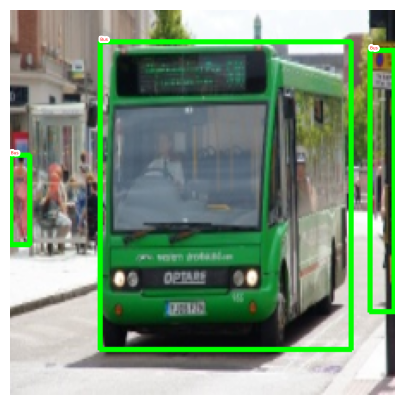

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Bus@0.99
Truck@0.13


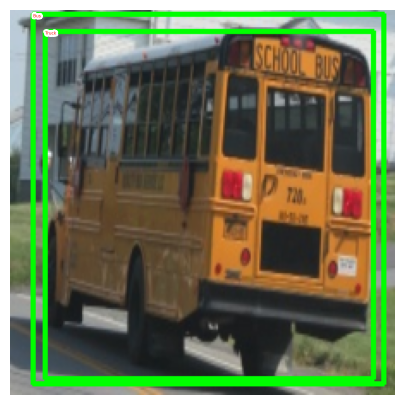

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Bus@1.00
Truck@0.39


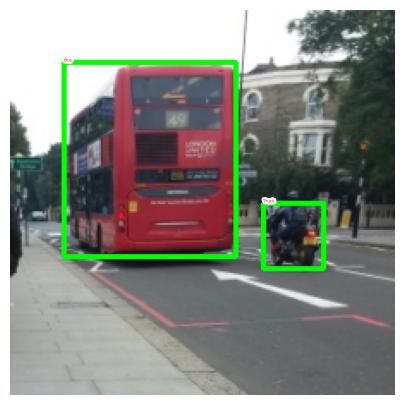

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Bus@1.00
Bus@0.99


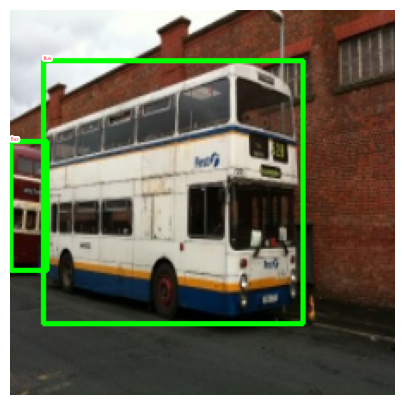

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Bus@0.93
Truck@0.36
Bus@0.08
Bus@0.08


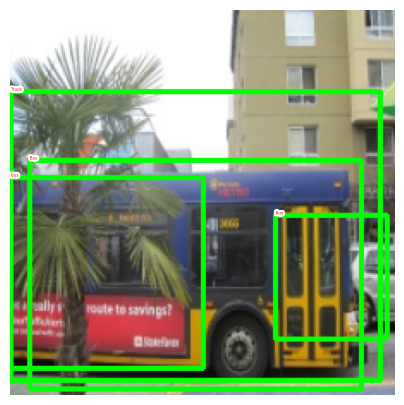

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Bus@1.00
Bus@0.33


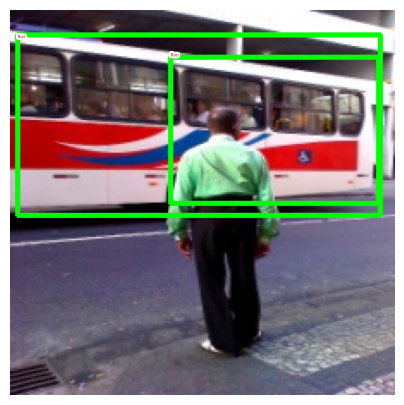

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Bus@1.00
Bus@0.06


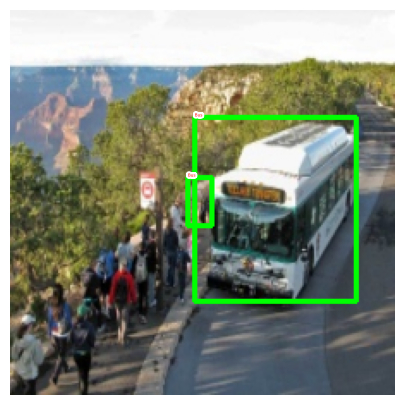

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Bus@0.79
Truck@0.59


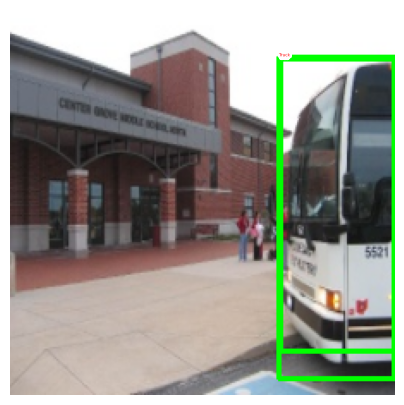

In [26]:
model.eval()
for batch in validate_loader:
    imgs, tgts = batch
    imgs = [img for img in imgs]
    outputs = model(imgs)
    for idx, output in enumerate(outputs):
        b_boxes, classes, scores = decode_output(output)
        for class_, score in zip(classes, scores):
            print(f"{class_}@{score:.2f}")
        show(imgs[idx].cpu().permute(1,2,0), bbs=b_boxes, texts=classes, sz=5)
    break